This notebook replicates the second experiment with LeNet on MNIST dataset from our paper "MARS: Masked Automatic Ranks Selection in Tensor Decompositions".

Compression mode: **compress** ($\pi = 10^{-2}$, $\alpha = -0.15$).

**Preliminaries**

In [1]:
import os

os.chdir("../main")

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

import torch
import numpy as np
import random

import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms

from mars import MARS, MARSLoss, get_MARS_attr, set_MARS_attr
from models import LeNet

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
seed = 228  # set random seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**Model and hyperparameters definition**

In [5]:
# Compression modes parameters
modes_dict = {
    "base": dict(pi=np.nan, alpha=np.nan),
    "compress": dict(pi=1e-2, alpha=-0.15)
}

In [6]:
# Hyperparameters section
# In this experiment, we take enough epochs to guarantee complete convergence.
# One can take fewer but adjust the temperature annealing schedule appropriately.
n_epochs = 100
batch_size = 128
lr = 1e-3
weight_decay = 0
gamma = 0.97
temp_anneal = lambda t: max(1e-2, gamma * t)

In [7]:
data_dir = "/home/sergej/data"
test_batch = 2048

# MNIST Dataset (Images and Labels)
trainset = datasets.MNIST(root=data_dir,
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

testset = datasets.MNIST(root=data_dir,
                         train=False,
                         transform=transforms.ToTensor())

# Dataset Loader (Input Pipline)
trainloader = torch.utils.data.DataLoader(dataset=trainset,
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(dataset=testset,
                                         batch_size=test_batch,
                                         shuffle=False)

**Functions definition**

In [8]:
def train_model(model_idx, mode="soft", save=True, load=True):
    """
    Train the model or load the trained one.
    
    Parameters are:
        model_idx : int
            Model index to load or save.
        mode : str in {'soft', 'hard'}
            Compression mode.
        save : bool
            Whether to save the trained model.
        load : bool
            Whether to load the trained model.
    """
    model_directory_path = f"../models/MNIST-LeNet/{mode}/"
    prefix = str(model_idx)
        
    model_path = model_directory_path + prefix + '-model.pt'
    losses_path = model_directory_path + prefix + '-losses.npy'
    print("Model path: ", model_path)

    if save and not os.path.exists(model_directory_path):
        os.makedirs(model_directory_path)
        
    model = LeNet(config, **modes_dict[mode]).to(device)
    
    if load and os.path.isfile(model_path):
        # load trained model parameters from disk
        model.load_state_dict(torch.load(model_path))
        losses = np.load(losses_path)
        print('Loaded model parameters from disk.')
        return model, losses
    
    mars_layers = [l for l in model.modules() if isinstance(l, MARS)]
    
    cross_entropy = nn.CrossEntropyLoss()
    criterion = MARSLoss(model, len(trainset), cross_entropy)
    
    optimizer_logits = optim.Adam(
        [p for n, p in model.named_parameters() if "logits_list" in n],
        lr=1e-4 # logits with custom lr and without wd
    )
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if "tensor_model.parameters" in n],
         'lr': lr},  # cores without wd
        {'params': [p for n, p in model.named_parameters() if ("logits_list" not in n) and ("tensor_model.parameters" not in n)], 
         'lr': lr, 'weight_decay': weight_decay},  # other parameters with wd
    ]
    optimizer = optim.AdamW(optimizer_grouped_parameters)
#     optimizer = optim.AdamW(model.parameters(), lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)
#     scheduler = optim.lr_scheduler.OneCycleLR(optimizer, **{
#         "steps_per_epoch": len(trainloader),
#         "epochs": n_epochs,
#         "anneal_strategy": "cos",
#         "max_lr": lr,
#         "pct_start": 0.1
#     })

    print("Training...")
    losses = []
    log_step = len(trainloader)
    best_train_acc = 0
    best_test_acc = 0
    
    for epoch in range(n_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        losses.append(0.0)
        
        model.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer_logits.zero_grad()
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses[-1] += loss.item()
            loss.backward()
            optimizer_logits.step()
            optimizer.step()
#             scheduler.step()

            # update statistics
            with torch.no_grad():
                running_loss += loss.item()
                predicted = outputs.argmax(-1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_acc = correct / total
#         test_acc = eval_model(model)
        temp = get_MARS_attr(model, "temperature")
        with torch.no_grad():
            logits = [l.cpu().numpy() for layer in mars_layers for l in layer.phi_logits_list]
            logits = np.concatenate(logits)
            logits_mean = np.mean(logits)
            logits_std = np.std(logits)
        print('[%d] \t Loss: %.3f \t Train Acc: %.2f%% \t T: %.3f \t logits mean: %.3f \t logits std: %.3f' % (
            epoch + 1, 
            running_loss / log_step,
            100 * train_acc,
#             100 * test_acc, 
            np.nan if temp is None else temp,
            logits_mean, logits_std
        ))
                
        losses[-1] /= i + 1
        
        scheduler.step()
        
        if save:
            if train_acc > best_train_acc:
                torch.save(model.state_dict(), model_path[:-3] + "-best_train.pt")
                best_train_acc = train_acc
                best_train_epoch = epoch + 1
#             if test_acc > best_test_acc:
#                 torch.save(model.state_dict(), model_path[:-3] + "-best_test.pt")
#                 best_test_acc = test_acc
#                 best_test_epoch = epoch + 1
        
        temp = get_MARS_attr(model, "temperature")
        if temp is not None:
            new_temp = temp_anneal(temp)
            set_MARS_attr(model, "temperature", new_temp)

    losses = np.array(losses)
    print('Finished Training.')
    print("Best train accuracy:\t%.2f%% on epoch %d" % (100 * best_train_acc, best_train_epoch))
#     print("Best test accuracy:\t%.2f%% on epoch %d" % (100 * best_test_acc, best_test_epoch))
    
    if save:
        torch.save(model.state_dict(), model_path)
        np.save(losses_path, losses)
        print('Saved model parameters to disk.')
    
    return model, losses

In [9]:
def eval_model(model):
    "Evaluate a single model on test set."
    model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            predicted = outputs.argmax(-1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [10]:
def eval_ensemble(models):
    "Evaluate the whole ensemble on test set."
    for model in models:
        model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = torch.stack([model(images) for model in models])
            outputs = torch.softmax(outputs, -1)
            outputs = outputs.mean(0)
                
            predicted = outputs.argmax(-1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [11]:
def get_comp_info(model):
    "Plot model masks probabilities, print compression info and return total compression."
    MARS_layers = [l for l in model.modules() if isinstance(l, MARS)]
    
    ranks_list = []
    totals, dofs = [], []

    for l in MARS_layers:
        print("Layer: ", l.tensorized_model)
        phi_logits_list = l.phi_logits_list
        F = l.F
        eval_logits_threshold = l.eval_logits_threshold
        p_threshold = F(torch.tensor(eval_logits_threshold)).item()
        ranks = []

        for m, logits in enumerate(phi_logits_list, 1):
            logits = logits.detach().cpu()
            probs = F(logits).data.numpy()
            
            plt.title(f"Mask {m}")
            plt.bar(np.arange(1, len(probs) + 1), probs)
            plt.xlabel('Rank')
            plt.ylabel(r'$\phi$ value')
            plt.hlines(p_threshold, 0, len(probs) + 1, linestyles='--')
            plt.text(0, p_threshold * 1.05, 'Rounding threshold')
            plt.show()

            rank = (logits > eval_logits_threshold).sum().item()
            print("#nz ranks: {0}/{1}".format(rank, len(logits)))
            ranks.append(rank)

        ranks_list.append(ranks)
        print()
        
        dofs.append(l.tensorized_model.calc_dof(ranks))
        totals.append(l.tensorized_model.total)
        comp = totals[-1] / dofs[-1]
        
        print("Compression:\t%.3f" % comp)
        print(100*"=")

    all_params = sum(p.numel() for p in model.parameters())
    mars_params = sum(logits.numel() for l in MARS_layers for logits in l.phi_logits_list)
    mars_params += sum(l.tensorized_model.calc_dof() for l in MARS_layers)
    other_params = all_params - mars_params
    
    total_comp = (other_params + sum(totals)) / (other_params + sum(dofs))
    print("Total compression:\t%.3f" % total_comp)
    
    return total_comp

**MARS training**

In [12]:
from dataclasses import dataclass

@dataclass
class MNISTLeNetConfig:
    mars_enabled = True

config = MNISTLeNetConfig()

In [13]:
%%time

model, loss = train_model(0, mode="compress")
acc = eval_model(model)
print(f"Accuracy of base model:\t%.2f%%" % (100 * acc))

Model path:  ../models/MNIST-LeNet/compress/0-model.pt
Training...
[1] 	 Loss: 0.906 	 Train Acc: 71.08% 	 T: 0.100 	 logits mean: -0.147 	 logits std: 0.009
[2] 	 Loss: 0.342 	 Train Acc: 90.16% 	 T: 0.097 	 logits mean: -0.144 	 logits std: 0.010
[3] 	 Loss: 0.253 	 Train Acc: 92.85% 	 T: 0.094 	 logits mean: -0.141 	 logits std: 0.010
[4] 	 Loss: 0.215 	 Train Acc: 93.86% 	 T: 0.091 	 logits mean: -0.138 	 logits std: 0.010
[5] 	 Loss: 0.189 	 Train Acc: 94.65% 	 T: 0.089 	 logits mean: -0.135 	 logits std: 0.011
[6] 	 Loss: 0.176 	 Train Acc: 95.06% 	 T: 0.086 	 logits mean: -0.132 	 logits std: 0.011
[7] 	 Loss: 0.157 	 Train Acc: 95.54% 	 T: 0.083 	 logits mean: -0.129 	 logits std: 0.011
[8] 	 Loss: 0.149 	 Train Acc: 95.83% 	 T: 0.081 	 logits mean: -0.126 	 logits std: 0.012
[9] 	 Loss: 0.141 	 Train Acc: 95.97% 	 T: 0.078 	 logits mean: -0.124 	 logits std: 0.012
[10] 	 Loss: 0.132 	 Train Acc: 96.24% 	 T: 0.076 	 logits mean: -0.121 	 logits std: 0.012
[11] 	 Loss: 0.127 	 T

[90] 	 Loss: 0.053 	 Train Acc: 98.56% 	 T: 0.010 	 logits mean: -0.003 	 logits std: 0.028
[91] 	 Loss: 0.051 	 Train Acc: 98.62% 	 T: 0.010 	 logits mean: -0.002 	 logits std: 0.028
[92] 	 Loss: 0.053 	 Train Acc: 98.52% 	 T: 0.010 	 logits mean: -0.001 	 logits std: 0.028
[93] 	 Loss: 0.052 	 Train Acc: 98.50% 	 T: 0.010 	 logits mean: 0.000 	 logits std: 0.028
[94] 	 Loss: 0.052 	 Train Acc: 98.56% 	 T: 0.010 	 logits mean: 0.001 	 logits std: 0.028
[95] 	 Loss: 0.054 	 Train Acc: 98.56% 	 T: 0.010 	 logits mean: 0.002 	 logits std: 0.028
[96] 	 Loss: 0.050 	 Train Acc: 98.66% 	 T: 0.010 	 logits mean: 0.003 	 logits std: 0.028
[97] 	 Loss: 0.052 	 Train Acc: 98.52% 	 T: 0.010 	 logits mean: 0.004 	 logits std: 0.028
[98] 	 Loss: 0.050 	 Train Acc: 98.64% 	 T: 0.010 	 logits mean: 0.005 	 logits std: 0.028
[99] 	 Loss: 0.051 	 Train Acc: 98.60% 	 T: 0.010 	 logits mean: 0.006 	 logits std: 0.029
[100] 	 Loss: 0.050 	 Train Acc: 98.64% 	 T: 0.010 	 logits mean: 0.006 	 logits std: 0

Layer:  Tucker Conv2d: [6, 16, 5, 5] -> [6, 20]-[20, 20, 5, 5]-[20, 16]


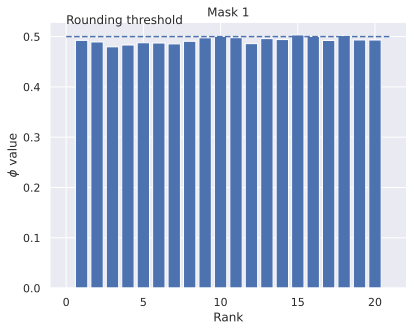

#nz ranks: 4/20


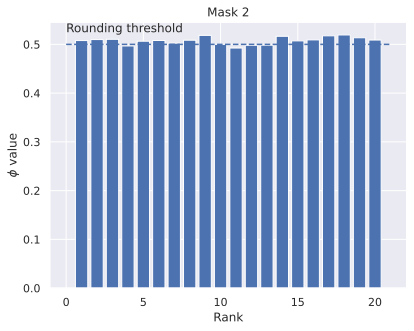

#nz ranks: 16/20

Compression:	1.277
Layer:  Factorized Linear: [400, 120] -> [400, 100]-[100, 120]


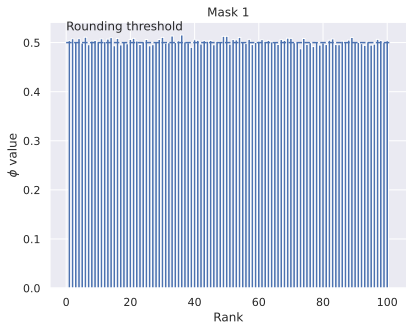

#nz ranks: 68/100

Compression:	1.357
Total compression:	1.340


In [14]:
comp = get_comp_info(model)

In [15]:
def time_model(model, device):
    model = model.to(device)
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)

%timeit time_model(model, "cuda")

202 ms ± 4.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit time_model(model, "cpu")

341 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**MARS ensemble training**

In [33]:
n_models = 10  # set the number of models in ensemble
mode = "compress"  # set the compression mode
models, losses = [], []

In [34]:
for k in range(1, n_models + 1):
    print(f"Model number {k}...")
    model, loss = train_model(k, mode)
    losses.append(loss)
    models.append(model)
    print()
    print(100*'=')
    print()

Model number 1...
Model path:  ../models/MNIST-LeNet/compress/1-model.pt
Training...


KeyboardInterrupt: 

In [ ]:
comps = []

for k, model in enumerate(models, 1):
    print(f"Model number {k}...")
    print()
    comps.append(get_comp_info(model))
    print()
    print()
    print(100*'-')
    print(100*'-')
    print(100*'-')
    print()
    print()

In [ ]:
accuracies = dict()

accuracies["marginal"] = []
for k, model in enumerate(models, 1):
    k_acc = eval_model(model)
    print(f"Accuracy of model {k}:\t%.2f%%" % (100 * k_acc))
    accuracies["marginal"].append(k_acc)
    
print()

ensemble_acc = eval_ensemble(models)
print('Accuracy of the ensemble:\t%.2f%%' % (100 * ensemble_acc))
accuracies["ensemble"] = ensemble_acc

In [ ]:
for k, comp in enumerate(comps, 1):
    print(f"Model {k} total compression:\t%.3f" % comp)